## Set up environement

In [286]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

In [395]:
import keras
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Data processing

In [288]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [289]:
def normalize(x_train, x_test):
    # compute mean and std for both train and test to make sure there is no bias between those two
    mean = (x_train.shape[0] * x_train.mean() + x_test.shape[0] * x_test.mean()) / (x_train.shape[0] + x_test.shape[0])
    std = (x_train.shape[0] * x_train.std() + x_test.shape[0] * x_test.std()) / (x_train.shape[0] + x_test.shape[0])
    
    return (x_train - mean) / std, (x_test - mean) / std

x_train, x_test = normalize(x_train, x_test)

In [107]:
def get_batch(x, y, size=1024):
    while True:
        x1_i = np.random.randint(x.shape[0], size=size)
        x1 = x[x1_i]
        y1 = y[x1_i]
        x2_i = np.zeros(size)
        x3_i = np.zeros(size)
        
        for label in range(10):
            x1_i_label = np.where(y1 == label)[0]

            # positive pair
            i_same_class = np.where(y == label)[0]
            x2_i_label = np.random.choice(i_same_class, size=x1_i_label.shape[0])
            x2_i[x1_i_label] = x2_i_label
            
            # negative pair
            i_diff_class = np.where(y != label)[0]
            x3_i_label = np.random.choice(i_diff_class, size=x1_i_label.shape[0])
            x3_i[x1_i_label] = x3_i_label
            
        yield x1, x[x2_i.astype(int)], x[x3_i.astype(int)]

## Building Triplet

In [309]:
compare_net = lambda x: keras.backend.sqrt(keras.backend.sum(keras.backend.square(x[0] - x[1]), axis=-1, keepdims=True))

softmax = lambda x: keras.backend.softmax(x)

In [383]:
def create_net():
    net = keras.models.Sequential()
    net.add(keras.layers.Conv2D(filters=1, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
    net.add(keras.layers.MaxPooling2D())
    net.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    net.add(keras.layers.MaxPooling2D())
    net.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    net.add(keras.layers.MaxPooling2D())
    net.add(keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    net.add(keras.layers.MaxPooling2D())
    net.add(keras.layers.Flatten())
    net.add(keras.layers.Dropout(0.2))
    
    return net

In [375]:
def create_model():
    input1 = keras.layers.Input(shape=(28, 28))
    input2 = keras.layers.Input(shape=(28, 28))
    input3 = keras.layers.Input(shape=(28, 28))
    reshape1 = keras.layers.Reshape((28, 28, 1))(input1)
    reshape2 = keras.layers.Reshape((28, 28, 1))(input2)
    reshape3 = keras.layers.Reshape((28, 28, 1))(input3)
    
    net = create_net()
    net1 = net(reshape1)
    net2 = net(reshape2)
    net3 = net(reshape3)
    
    compare_net1 = keras.layers.Lambda(compare_net)([net1, net2])
    compare_net2 = keras.layers.Lambda(compare_net)([net1, net3])
    
    merge = keras.layers.Concatenate()([compare_net1, compare_net2])
    out = keras.layers.Lambda(softmax)(merge)
    
    model = keras.models.Model(inputs=[input1, input2, input3], outputs=[out])
    
    # decay is not specified
    opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(opt, loss='mean_squared_error')
    
    return net, model

## Training

In [401]:
net, model = create_model()
model.summary()

board = keras.callbacks.TensorBoard()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_288 (InputLayer)          (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_289 (InputLayer)          (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_290 (InputLayer)          (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_286 (Reshape)           (None, 28, 28, 1)    0           input_288[0][0]                  
__________________________________________________________________________________________________
reshape_28

In [402]:
batch_size = 640000
val_size = 64000
nb_epochs = 7

loss = []
val_loss = []

y = np.ones((batch_size, 2))
y[:, 0] = 0

epoch = 0
for (x1_train, x2_train, x3_train), (x1_val, x2_val, x3_val) in \
        zip(
            get_batch(x_train, y_train, size=batch_size), 
            get_batch(x_test, y_test, size=val_size)
        ):
    h = model.fit([x1_train, x2_train, x3_train], y, 
                  validation_data=([x1_val, x2_val, x3_val], y[:val_size]),
                  shuffle=False, 
                  callbacks=[board], 
                  epochs=epoch+1 ,initial_epoch=epoch)
    
    loss.append(h.history['loss'])
    val_loss.append(h.history['val_loss'])
    
    epoch += 1
    if epoch == nb_epochs:
        break

Train on 640000 samples, validate on 64000 samples
Epoch 1/1
640000/640000 [==============================] - 141s 220us/step - loss: 0.0192 - val_loss: 0.0039
Train on 640000 samples, validate on 64000 samples
Epoch 2/2
640000/640000 [==============================] - 137s 214us/step - loss: 0.0074 - val_loss: 0.0023
Train on 640000 samples, validate on 64000 samples
Epoch 3/3
640000/640000 [==============================] - 138s 216us/step - loss: 0.0055 - val_loss: 0.0021
Train on 640000 samples, validate on 64000 samples
Epoch 4/4
640000/640000 [==============================] - 137s 215us/step - loss: 0.0047 - val_loss: 0.0024
Train on 640000 samples, validate on 64000 samples
Epoch 5/5
640000/640000 [==============================] - 138s 215us/step - loss: 0.0040 - val_loss: 0.0019
Train on 640000 samples, validate on 64000 samples
Epoch 6/6
640000/640000 [==============================] - 137s 215us/step - loss: 0.0036 - val_loss: 0.0016
Train on 640000 samples, validate on 640

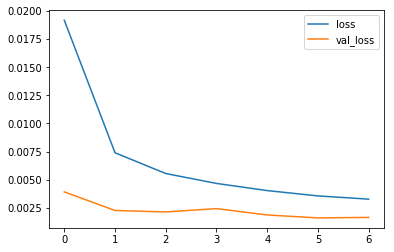

In [406]:
x_plot = np.arange(nb_epochs)
plt.plot(x_plot, loss, label='loss')
plt.plot(x_plot, val_loss, label='val_loss')
plt.legend()
plt.show()

In [403]:
knn = KNeighborsClassifier(5)
x_train_representations = net.predict(x_train.reshape(-1, 28, 28, 1))
knn.fit(x_train_representations, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

## Testing

In [404]:
x_test_representations = net.predict(x_test.reshape(-1, 28, 28, 1))
knn.score(x_test_representations, y_test)

0.9906

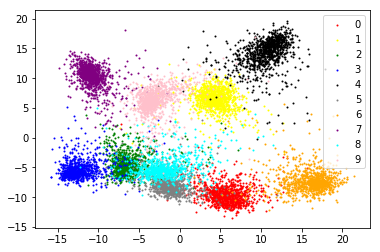

In [405]:
pca = PCA(2)
pca_result = pca.fit_transform(x_test_representations)

colors = ['red', 'yellow', 'green', 'blue', 'black', 'grey', 'orange', 'purple', 'cyan', 'pink']
for label in range(10):
    plt.scatter(pca_result[y_test == label][:, 0], pca_result[y_test == label][:, 1], 
                s=1,
                color=colors[label], 
                label=label)
plt.legend()
plt.show()